In [2]:
import numpy as np
import cvxpy as cp
from scipy import optimize
from nldg.utils import max_mse, min_xplvar, gen_data_v2, gen_data_v3
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng

In [3]:
#dtr = gen_data_v3(n=1000, setting=2)
dtr = gen_data_v2(n=1000)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Ytr = Ytr - np.mean(Ytr)
dtr['Y'] = Ytr
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)

In [4]:
all_idx = default_rng(0).choice(np.arange(0, Xtr.shape[0]), size=Ytr.shape[0], replace=True)

Y_sample = Ytr[all_idx].flatten()
X_sample = Xtr[all_idx].flatten()
E_sample = Etr[all_idx].flatten()
unique_envs = np.unique(E_sample)

In [5]:
c_init = cp.Variable(1)
t = cp.Variable(nonneg=True)
constraints = []
for env in unique_envs:
    Y_e = Y_sample[E_sample == env]
    constraints.append(cp.mean(cp.square(Y_e - c_init)) <= t)
objective = cp.Minimize(t)
problem = cp.Problem(objective, constraints)
problem.solve()
best_preds = np.array([c_init.value] * Y_sample.shape[0])

In [6]:
c_init.value

array([0.02000007])

In [7]:
alpha = 0.1 * objective.value
alpha

np.float64(0.03317418753172859)

In [8]:
objective.value + alpha

np.float64(0.3649160628490145)

In [9]:
from collections import Counter
from numba import njit


indices = all_idx

# 1. Sort indices by the splitting feature
order = np.argsort(Xtr[indices].flatten())
sorted_indices = indices[order]
sorted_X = Xtr[sorted_indices]
sorted_Y = Ytr[sorted_indices]
sorted_E = Etr[sorted_indices]

# 2. Precompute per-env prefix sums & prefix squared-sums
N = len(sorted_indices)
n_envs = len(unique_envs)
env_idx = np.arange(n_envs)[:, None]
mask_mat = (sorted_E[None, :] == env_idx)

prefix_count_mat = np.concatenate(
    [np.zeros((n_envs,1),int), np.cumsum(mask_mat, axis=1)], axis=1
)

Y_mat = sorted_Y[None, :] * mask_mat
prefix_sum_mat = np.concatenate(
    [np.zeros((n_envs,1)), np.cumsum(Y_mat, axis=1)], axis=1
)
prefix_sq_mat = np.concatenate(
    [np.zeros((n_envs,1)), np.cumsum((Y_mat * sorted_Y[None,:]), axis=1)], axis=1
)

suffix_count_mat = np.zeros((n_envs, N + 1))
suffix_sum_mat = np.zeros((n_envs, N + 1))
suffix_sq_mat = np.zeros((n_envs, N + 1))

for e in range(n_envs):
    suffix_count_mat[e, N] = 0
    suffix_sum_mat[e, N] = 0.0
    suffix_sq_mat[e, N] = 0.0

for j in range(N - 1, -1, -1):
    for e in range(n_envs):
        m = 1 if sorted_E[j] == e else 0
        suffix_count_mat[e, j] = suffix_count_mat[e, j + 1] + m
        suffix_sum_mat[e, j] = suffix_sum_mat[e, j + 1] + m * sorted_Y[j]
        suffix_sq_mat[e, j] = suffix_sq_mat[e, j + 1] + m * (sorted_Y[j] ** 2)

total_count = np.zeros(n_envs)
for e in range(n_envs):
    total_count[e] = np.sum(Etr[all_idx] == e)

# 4. Precompute "remaining" loss per env (here remaining = none if all_idx used)
diff = Counter(all_idx) - Counter(indices)
remaining = np.array(list(diff.elements()), dtype=np.intc)
rem_loss_vec = np.zeros(n_envs)
if remaining.size > 0:
    mask_rem = (Etr[remaining][None, :] == env_idx)
    Y_rem    = Ytr[remaining][None, :] * mask_rem
    P_rem    = best_preds[remaining][None, :] * mask_rem
    errs_sq  = (Y_rem - P_rem) ** 2
    rem_loss_vec = errs_sq.sum(axis=1)

# 5. Build the CVXPY problem once using Parameters
cL = cp.Variable(1)
cR = cp.Variable(1)
t  = cp.Variable()
#mean_diff_p = cp.Parameter(nonneg=True)
max_diff = cp.Parameter(nonneg=True)

# Parameters for left & right sums
S0_L = cp.Parameter(n_envs, nonneg=True)
S1_L = cp.Parameter(n_envs)
n_L  = cp.Parameter(n_envs, nonneg=True)
S0_R = cp.Parameter(n_envs, nonneg=True)
S1_R = cp.Parameter(n_envs)
n_R  = cp.Parameter(n_envs, nonneg=True)
R    = cp.Parameter(n_envs, nonneg=True)

def quad_term(c, S0, S1, n):
    # S0 - 2 c * S1 + n * c^2
    return S0 - 2 * c * S1 + n * c**2

# elementwise env losses <= t
loss_vec = (quad_term(cL, S0_L, S1_L, n_L)
          + quad_term(cR, S0_R, S1_R, n_R)
          + R) / total_count
constraints = [loss_vec <= t]
#objective   = cp.Minimize(t + alpha * mean_diff_p ** (-1))
objective   = cp.Minimize(t + alpha * max_diff)
problem     = cp.Problem(objective, constraints)

# 6. Loop over splits, update parameters, solve
best_score = np.inf
best_split = None
best_vals  = None

#@njit
#def compute_mean_diff(prefix_count, prefix_sum, suffix_count, suffix_sum, i):
#    K = prefix_count.shape[0]
#    s = 0.0
#    c = 0
#    for e in range(K):
#        nL = prefix_count[e, i]
#        nR = suffix_count[e, i]
#        if nL > 0 and nR > 0:
#            mL = prefix_sum[e, i] / nL
#            mR = suffix_sum[e, i] / nR
#            s += abs(mR - mL)
#            c += 1
#    return s / c if c > 0 else 0.0

@njit
def compute_max_prop_balance(prefix_count, suffix_count, total_count, i):
    K = prefix_count.shape[0]
    max_left_prop = 0.0
    max_right_prop = 0.0

    for e in range(K):
        total = total_count[e]
        if total > 0:
            left_prop = prefix_count[e, i] / total
            right_prop = suffix_count[e, i] / total

            if left_prop > max_left_prop:
                max_left_prop = left_prop

            if right_prop > max_right_prop:
                max_right_prop = right_prop

    return abs(max_left_prop - max_right_prop)

#for i in range(1, N):
for i in [476]:
    # mean-diff vectorized
    #mean_diff_p.value = compute_mean_diff(
    #    prefix_count_mat, prefix_sum_mat,
    #    suffix_count_mat, suffix_sum_mat, i
    #)
    max_diff.value = compute_max_prop_balance(
        prefix_count_mat, suffix_count_mat, total_count, i
    )

    # update S0, S1, n for left & right
    S0_L.value = prefix_sq_mat[:, i]
    S1_L.value = prefix_sum_mat[:, i]
    n_L.value  = prefix_count_mat[:, i]

    S0_R.value = suffix_sq_mat[:, i]
    S1_R.value = suffix_sum_mat[:, i]
    n_R.value  = suffix_count_mat[:, i]

    R.value    = rem_loss_vec

    problem.solve(warm_start=True)

    if problem.value < best_score:
        best_score = problem.value
        best_split = i
        best_vals  = (cL.value, cR.value, t.value)

In [10]:
t.value

array(0.31621206)

In [11]:
n1 = np.sum(E_sample == 0)
n2 = np.sum(E_sample == 1)
n1_L = n_L.value[0]
n2_L = n_L.value[1]
n1_R = n_R.value[0]
n2_R = n_R.value[1]
K1 = rem_loss_vec[0]
K2 = rem_loss_vec[1]
sum_sq_1 = S0_L.value[0] + S0_R.value[0]
sum_sq_2 = S0_L.value[1] + S0_R.value[1]
mu1_L = S1_L.value[0] / n1_L
mu2_L = S1_L.value[1] / n2_L
mu1_R = S1_R.value[0] / n1_R
mu2_R = S1_R.value[1] / n2_R

In [12]:
1 / n1 * (sum_sq_1 + n1_L * cL.value ** 2 - 2 * n1_L * cL.value * mu1_L + n1_R * cR.value ** 2 - 2 * n1_R * cR.value * mu1_R + K1)

array([0.31621206])

In [13]:
1 / n2 * (sum_sq_2 + n2_L * cL.value ** 2 - 2 * n2_L * cL.value * mu2_L + n2_R * cR.value ** 2 - 2 * n2_R * cR.value * mu2_R + K2)

array([0.31621206])

In [14]:
best_score

np.float64(0.3166004677778418)

In [15]:
best_split

476

In [16]:
best_vals[0]

array([-0.00300014])

In [17]:
best_vals[1]

array([0.05183524])

In [18]:
best_preds = np.array([c_init.value] * Y_sample.shape[0]).flatten()
best_preds[sorted_indices[:best_split]] = best_vals[0]
best_preds[sorted_indices[best_split:]] = best_vals[1]

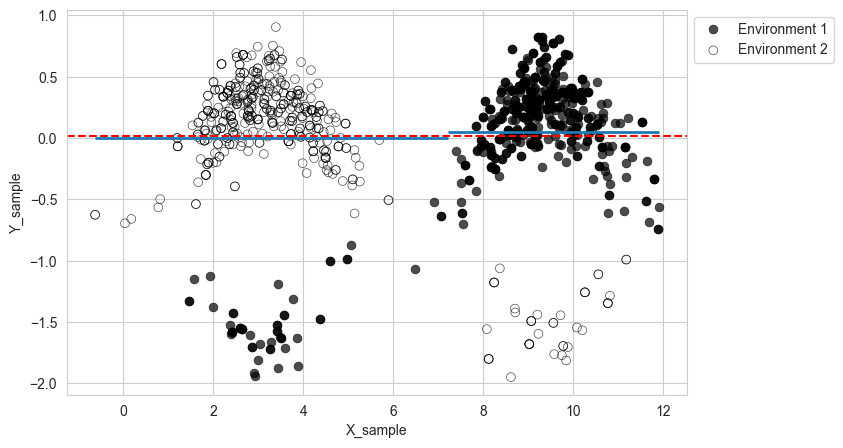

In [19]:
dtr['E_sample'] = E_sample
dtr['Y_sample'] = Y_sample
dtr['X_sample'] = X_sample
dtr["best_preds"] = best_preds

plt.figure(figsize=(8, 5))

# Plot data points
sns.scatterplot(
    data=dtr[dtr["E_sample"] == dtr["E_sample"].unique()[0]],
    x="X_sample", y="Y_sample",
    color="black", edgecolor="black",
    s=40, alpha=0.7, label="Environment 1"
)

sns.scatterplot(
    data=dtr[dtr["E_sample"] == dtr["E_sample"].unique()[1]],
    x="X_sample", y="Y_sample",
    facecolors='none', edgecolor="black",
    s=40, alpha=0.7, label="Environment 2",
    marker="o"
)

#sns.scatterplot(
#    data=dtr[dtr["E_sample"] == dtr["E_sample"].unique()[2]],
#    x="X_sample", y="Y_sample",
#    facecolors="none", edgecolor="black",
#    s=40, alpha=0.7, label="Environment 3",
#    marker="D"
#)

# Plot the minimax constant prediction
plt.axhline(y=c_init.value, color='r', linestyle='--')

# Plot the step function from left to right
threshold = (sorted_X[best_split-1] + sorted_X[best_split]) / 2.0
plt.hlines(y=best_vals[0], xmin=dtr["X"].min(), xmax=threshold, linestyle='-', linewidth=2)
plt.hlines(y=best_vals[1], xmin=threshold, xmax=dtr["X"].max(), linestyle='-', linewidth=2)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [26]:
#import sympy as sp
#
#lam = sp.symbols('lam')
#n1_L, n2_L, mu1_L, mu2_L, n1_R, n2_R, mu1_R, mu2_R, sum_sq_1, sum_sq_2, n1, n2, K1, K2 = sp.symbols(
#    'n1_L n2_L mu1_L mu2_L n1_R n2_R mu1_R mu2_R sum_sq_1 sum_sq_2 n1 n2 K1 K2'
#)
#
#cL = (lam * n1_L * mu1_L + (1 - lam) * n2_L * mu2_L) / (lam * n1_L + (1 - lam) * n2_L)
#cR = (lam * n1_R * mu1_R + (1 - lam) * n2_R * mu2_R) / (lam * n1_R + (1 - lam) * n2_R)
#
#f1 = 1/n1 * (sum_sq_1 + n1_L * cL ** 2 - 2 * n1_L * cL * mu1_L + n1_R * cR ** 2 - 2 * n1_R * cR * mu1_R + K1)
#f2 = 1/n2 * (sum_sq_2 + n2_L * cL ** 2 - 2 * n2_L * cL * mu2_L + n2_R * cR ** 2 - 2 * n2_R * cR * mu2_R + K2)
#
#equation = sp.simplify(f1 - f2)
#
#num, den = sp.simplify(equation).as_numer_denom()
#poly = sp.factor(num)
#
#sp.solve(poly, lam, check=False, simplify=False)
#
#n1 = np.sum(E_sample == 0)
#n2 = np.sum(E_sample == 1)
#n1_L = n_L.value[0]
#n2_L = n_L.value[1]
#n1_R = n_R.value[0]
#n2_R = n_R.value[1]
#K1 = rem_loss_vec[0]
#K2 = rem_loss_vec[1]
#sum_sq_1 = S0_L.value[0] + S0_R.value[0]
#sum_sq_2 = S0_L.value[1] + S0_R.value[1]
#mu1_L = S1_L.value[0] / n1_L
#mu2_L = S1_L.value[1] / n2_L
#mu1_R = S1_R.value[0] / n1_R
#mu2_R = S1_R.value[1] / n2_R
#
#lam = expression got with sp.solve
#
#cL = (lam * n1_L * mu1_L + (1 - lam) * n2_L * mu2_L) / (lam * n1_L + (1 - lam) * n2_L)
#cL
#
#cR = (lam * n1_R * mu1_R + (1 - lam) * n2_R * mu2_R) / (lam * n1_R + (1 - lam) * n2_R)
#cR
#
#1/n1 * (sum_sq_1 + n1_L * cL ** 2 - 2 * n1_L * cL * mu1_L + n1_R * cR ** 2 - 2 * n1_R * cR * mu1_R + K1)
#
#1/n2 * (sum_sq_2 + n2_L * cL ** 2 - 2 * n2_L * cL * mu2_L + n2_R * cR ** 2 - 2 * n2_R * cR * mu2_R + K2)

In [31]:
def equation_to_solve(lam):
    # Calculate cL and cR based on lambda
    cL = (lam * n1_L * mu1_L + (1 - lam) * n2_L * mu2_L) / (lam * n1_L + (1 - lam) * n2_L)
    cR = (lam * n1_R * mu1_R + (1 - lam) * n2_R * mu2_R) / (lam * n1_R + (1 - lam) * n2_R)

    # Calculate f1 and f2
    f1 = 1/n1 * (sum_sq_1 + n1_L * cL**2 - 2 * n1_L * cL * mu1_L +
                 n1_R * cR**2 - 2 * n1_R * cR * mu1_R + K1)

    f2 = 1/n2 * (sum_sq_2 + n2_L * cL**2 - 2 * n2_L * cL * mu2_L +
                 n2_R * cR**2 - 2 * n2_R * cR * mu2_R + K2)

    # Return the difference
    return f1 - f2

optimize.root_scalar(equation_to_solve, bracket=[0, 1], method='brentq')

      converged: True
           flag: converged
 function_calls: 9
     iterations: 8
           root: 0.5051344669301212
         method: brentq

In [21]:
lam = 0.5051344669301212

cL = (lam * n1_L * mu1_L + (1 - lam) * n2_L * mu2_L) / (lam * n1_L + (1 - lam) * n2_L)
cL

np.float64(-0.0029866872832053377)

In [22]:
cR = (lam * n1_R * mu1_R + (1 - lam) * n2_R * mu2_R) / (lam * n1_R + (1 - lam) * n2_R)
cR

np.float64(0.051851602366816595)

In [23]:
1/n1 * (sum_sq_1 + n1_L * cL ** 2 - 2 * n1_L * cL * mu1_L + n1_R * cR ** 2 - 2 * n1_R * cR * mu1_R + K1)

np.float64(0.3162120581119042)

In [24]:
1/n2 * (sum_sq_2 + n2_L * cL ** 2 - 2 * n2_L * cL * mu2_L + n2_R * cR ** 2 - 2 * n2_R * cR * mu2_R + K2)

np.float64(0.316212058111904)

Optimal t = 6945.112454489968
Optimal prediction for Region 0 (X < -4.0): [5.59263275]
Optimal prediction for Region 1 (-4.0 <= X < -2.0): [2.4888131]
Optimal prediction for Region 2 (-2.0 <= X < 0.0): [-1.38439039]
Optimal prediction for Region 3 (0.0 <= X < 2.0): [-1.058206]
Optimal prediction for Region 4 (2.0 <= X < 4.0): [2.22791773]
Optimal prediction for Region 5 (X >= 4.0): [5.51044439]


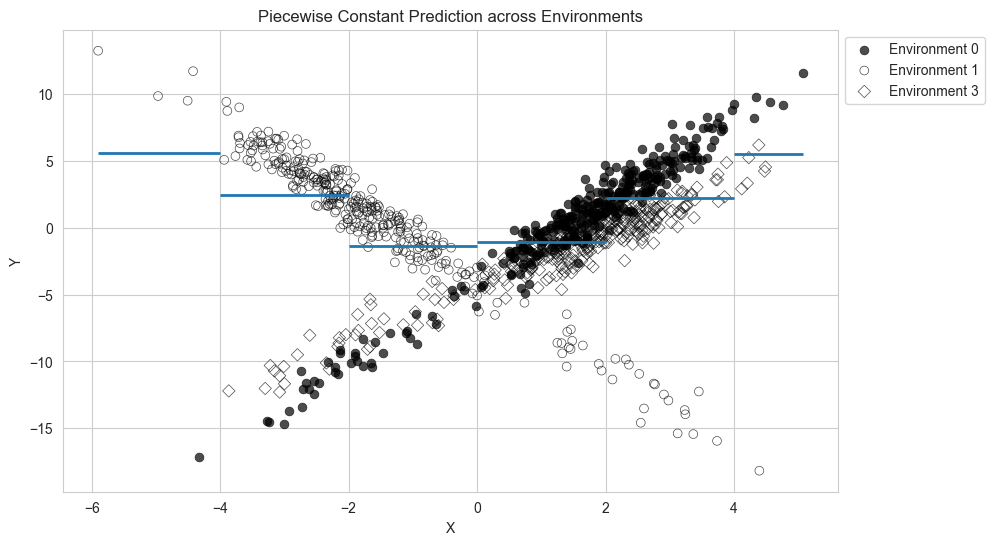

In [244]:
thresholds = [-4, -2, 0, 2, 4]  # thresholds: 2, 4, 6, 8, 11

# Define the region masks based on X
mask_region0 = dtr["X"] < thresholds[0]
mask_region1 = (dtr["X"] >= thresholds[0]) & (dtr["X"] < thresholds[1])
mask_region2 = (dtr["X"] >= thresholds[1]) & (dtr["X"] < thresholds[2])
mask_region3 = (dtr["X"] >= thresholds[2]) & (dtr["X"] < thresholds[3])
mask_region4 = (dtr["X"] >= thresholds[3]) & (dtr["X"] < thresholds[4])
mask_region5 = dtr["X"] >= thresholds[4]

# Split the data by environment.
unique_envs = dtr["E"].unique()
mask_env0 = dtr["E"] == unique_envs[0]
mask_env1 = dtr["E"] == unique_envs[1]

# For each environment and region, extract the corresponding Y values as numpy arrays.
Y_env0_0 = dtr.loc[mask_env0 & mask_region0, "Y"].values
Y_env0_1 = dtr.loc[mask_env0 & mask_region1, "Y"].values
Y_env0_2 = dtr.loc[mask_env0 & mask_region2, "Y"].values
Y_env0_3 = dtr.loc[mask_env0 & mask_region3, "Y"].values
Y_env0_4 = dtr.loc[mask_env0 & mask_region4, "Y"].values
Y_env0_5 = dtr.loc[mask_env0 & mask_region5, "Y"].values

Y_env1_0 = dtr.loc[mask_env1 & mask_region0, "Y"].values
Y_env1_1 = dtr.loc[mask_env1 & mask_region1, "Y"].values
Y_env1_2 = dtr.loc[mask_env1 & mask_region2, "Y"].values
Y_env1_3 = dtr.loc[mask_env1 & mask_region3, "Y"].values
Y_env1_4 = dtr.loc[mask_env1 & mask_region4, "Y"].values
Y_env1_5 = dtr.loc[mask_env1 & mask_region5, "Y"].values

# --- Set up the Optimization Problem ---
# Define six scalar prediction variables, one per region.
c0 = cp.Variable(1)
c1 = cp.Variable(1)
c2 = cp.Variable(1)
c3 = cp.Variable(1)
c4 = cp.Variable(1)
c5 = cp.Variable(1)

# t is the common upper bound on the sum of squared errors in each environment.
t = cp.Variable(nonneg=True)

# Build constraints for each environment (sum of squared errors in each environment <= t)
constraints = []

# For environment 0, add the sum of squared errors over all regions.
constraints.append(
    cp.sum(cp.square(Y_env0_0 - c0)) +
    cp.sum(cp.square(Y_env0_1 - c1)) +
    cp.sum(cp.square(Y_env0_2 - c2)) +
    cp.sum(cp.square(Y_env0_3 - c3)) +
    cp.sum(cp.square(Y_env0_4 - c4)) +
    cp.sum(cp.square(Y_env0_5 - c5))
    <= t
)

# For environment 1:
constraints.append(
    cp.sum(cp.square(Y_env1_0 - c0)) +
    cp.sum(cp.square(Y_env1_1 - c1)) +
    cp.sum(cp.square(Y_env1_2 - c2)) +
    cp.sum(cp.square(Y_env1_3 - c3)) +
    cp.sum(cp.square(Y_env1_4 - c4)) +
    cp.sum(cp.square(Y_env1_5 - c5))
    <= t
)

# Define the objective to minimize the worst-case error t
objective = cp.Minimize(t)

# Solve the optimization problem
problem = cp.Problem(objective, constraints)
result = problem.solve()

print("Optimal t =", result)
print("Optimal prediction for Region 0 (X < {:.1f}): {}".format(thresholds[0], c0.value))
print("Optimal prediction for Region 1 ({:.1f} <= X < {:.1f}): {}".format(thresholds[0], thresholds[1], c1.value))
print("Optimal prediction for Region 2 ({:.1f} <= X < {:.1f}): {}".format(thresholds[1], thresholds[2], c2.value))
print("Optimal prediction for Region 3 ({:.1f} <= X < {:.1f}): {}".format(thresholds[2], thresholds[3], c3.value))
print("Optimal prediction for Region 4 ({:.1f} <= X < {:.1f}): {}".format(thresholds[3], thresholds[4], c4.value))
print("Optimal prediction for Region 5 (X >= {:.1f}): {}".format(thresholds[4], c5.value))

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Plot the data points for each environment.
# For Environment 1, plot as filled circles.
sns.scatterplot(
    data=dtr[dtr["E"] == unique_envs[0]],
    x="X", y="Y",
    color="black", edgecolor="black",
    s=40, alpha=0.7, label="Environment {}".format(unique_envs[0])
)

# For Environment 2, plot with empty markers.
sns.scatterplot(
    data=dtr[dtr["E"] == unique_envs[1]],
    x="X", y="Y",
    facecolors='none', edgecolor="black",
    s=40, alpha=0.7, label="Environment {}".format(unique_envs[1])
)

sns.scatterplot(
    data=dtr[dtr["E"] == dtr["E"].unique()[2]],
    x="X", y="Y",
    facecolors="none", edgecolor="black",
    s=40, alpha=0.7, label="Environment 3",
    marker="D"
)

# Draw horizontal lines showing the predictions in each region.
x_min = dtr["X"].min()
x_max = dtr["X"].max()

# Region 0: from x_min to thresholds[0]
plt.hlines(y=c0.value, xmin=x_min, xmax=thresholds[0], linestyle='-', linewidth=2)
# Region 1: from thresholds[0] to thresholds[1]
plt.hlines(y=c1.value, xmin=thresholds[0], xmax=thresholds[1], linestyle='-', linewidth=2)
# Region 2: from thresholds[1] to thresholds[2]
plt.hlines(y=c2.value, xmin=thresholds[1], xmax=thresholds[2], linestyle='-', linewidth=2)
# Region 3: from thresholds[2] to thresholds[3]
plt.hlines(y=c3.value, xmin=thresholds[2], xmax=thresholds[3], linestyle='-', linewidth=2)
# Region 4: from thresholds[3] to thresholds[4]
plt.hlines(y=c4.value, xmin=thresholds[3], xmax=thresholds[4], linestyle='-', linewidth=2)
# Region 5: from thresholds[4] to x_max
plt.hlines(y=c5.value, xmin=thresholds[4], xmax=x_max, linestyle='-', linewidth=2)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Piecewise Constant Prediction across Environments")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


Optimal t = 7773.176052623124
Optimal prediction for Region 0 (X < 0.0): [1.08039625]
Optimal prediction for Region 1 (0.0 <= X < 2.0): [-1.42018931]
Optimal prediction for Region 2 (X >= 2.0): [1.54022591]


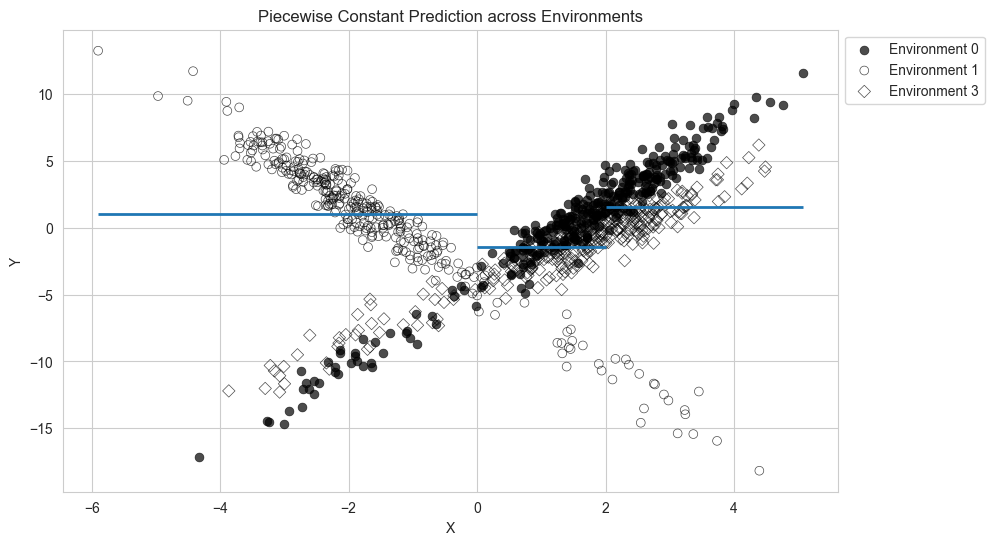

In [248]:
thresholds = [0, 2]

# Define the region masks based on X
mask_region0 = dtr["X"] < thresholds[0]
mask_region1 = (dtr["X"] >= thresholds[0]) & (dtr["X"] < thresholds[1])
mask_region2 = dtr["X"] >= thresholds[1]

# Split the data by environment.
unique_envs = dtr["E"].unique()
mask_env0 = dtr["E"] == unique_envs[0]
mask_env1 = dtr["E"] == unique_envs[1]

# For each environment and region, extract the corresponding Y values as numpy arrays.
Y_env0_0 = dtr.loc[mask_env0 & mask_region0, "Y"].values
Y_env0_1 = dtr.loc[mask_env0 & mask_region1, "Y"].values
Y_env0_2 = dtr.loc[mask_env0 & mask_region2, "Y"].values

Y_env1_0 = dtr.loc[mask_env1 & mask_region0, "Y"].values
Y_env1_1 = dtr.loc[mask_env1 & mask_region1, "Y"].values
Y_env1_2 = dtr.loc[mask_env1 & mask_region2, "Y"].values

# --- Set up the Optimization Problem ---
c0 = cp.Variable(1)
c1 = cp.Variable(1)
c2 = cp.Variable(1)

# t is the common upper bound on the sum of squared errors in each environment.
t = cp.Variable(nonneg=True)

# Build constraints for each environment (sum of squared errors in each environment <= t)
constraints = []

# For environment 0, add the sum of squared errors over all regions.
constraints.append(
    cp.sum(cp.square(Y_env0_0 - c0)) +
    cp.sum(cp.square(Y_env0_1 - c1)) +
    cp.sum(cp.square(Y_env0_2 - c2))
    <= t
)

# For environment 1:
constraints.append(
    cp.sum(cp.square(Y_env1_0 - c0)) +
    cp.sum(cp.square(Y_env1_1 - c1)) +
    cp.sum(cp.square(Y_env1_2 - c2))
    <= t
)

# Define the objective to minimize the worst-case error t
objective = cp.Minimize(t)

# Solve the optimization problem
problem = cp.Problem(objective, constraints)
result = problem.solve()

print("Optimal t =", result)
print("Optimal prediction for Region 0 (X < {:.1f}): {}".format(thresholds[0], c0.value))
print("Optimal prediction for Region 1 ({:.1f} <= X < {:.1f}): {}".format(thresholds[0], thresholds[1], c1.value))
print("Optimal prediction for Region 2 (X >= {:.1f}): {}".format(thresholds[1], c2.value))

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Plot the data points for each environment.
# For Environment 1, plot as filled circles.
sns.scatterplot(
    data=dtr[dtr["E"] == unique_envs[0]],
    x="X", y="Y",
    color="black", edgecolor="black",
    s=40, alpha=0.7, label="Environment {}".format(unique_envs[0])
)

# For Environment 2, plot with empty markers.
sns.scatterplot(
    data=dtr[dtr["E"] == unique_envs[1]],
    x="X", y="Y",
    facecolors='none', edgecolor="black",
    s=40, alpha=0.7, label="Environment {}".format(unique_envs[1])
)

sns.scatterplot(
    data=dtr[dtr["E"] == dtr["E"].unique()[2]],
    x="X", y="Y",
    facecolors="none", edgecolor="black",
    s=40, alpha=0.7, label="Environment 3",
    marker="D"
)

# Draw horizontal lines showing the predictions in each region.
x_min = dtr["X"].min()
x_max = dtr["X"].max()

# Region 0: from x_min to thresholds[0]
plt.hlines(y=c0.value, xmin=x_min, xmax=thresholds[0], linestyle='-', linewidth=2)
# Region 1: from thresholds[0] to thresholds[1]
plt.hlines(y=c1.value, xmin=thresholds[0], xmax=thresholds[1], linestyle='-', linewidth=2)
# Region 2: from thresholds[1] to x_max
plt.hlines(y=c2.value, xmin=thresholds[1], xmax=x_max, linestyle='-', linewidth=2)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Piecewise Constant Prediction across Environments")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

### Test adaXT

In [1]:
import numpy as np
from nldg.utils import max_mse, min_xplvar, gen_data_v2, gen_data_v3
import matplotlib.pyplot as plt
import seaborn as sns
from adaXT.random_forest import RandomForest

In [2]:
dtr = gen_data_v2(n=1000)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Ytr = Ytr - np.mean(Ytr)
dtr['Y'] = Ytr
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)
min_samples_leaf = 10
random_state = 42

In [3]:
rf = RandomForest("MaximinRegression",
                  n_estimators=1,
                  min_samples_leaf=min_samples_leaf,
                  seed=0,
                  #max_depth=1
                  )
rf.fit(Xtr, Ytr, Etr)
fitted = rf.predict(Xtr)

0.03266034856758632 0.32660348567586317
[0.03228349] 0.3592638342434495
-------------------------------------------------------
1000
Remaining:  0 [0. 0.]
Best split:  473 4.94940289546923
Impurity:  0.3592638342434495 0.3238893354845829
Best values:  [ 0.06881169 -0.01322718]
Best preds:  (array([-0.01322718,  0.06881169]), array([527, 473]))
-------------------------------------------------------
527
Remaining:  473 [40.46941101 91.96836405]
Best split:  60 8.143048249186124
Impurity:  0.3238893354845829 0.2941787162637348
Best values:  [-0.48175873 -0.01708399]
Best preds:  (array([-0.48175873, -0.01708399,  0.06881169]), array([ 60, 467, 473]))
-------------------------------------------------------
467
Remaining:  533 [44.51796475 96.6058684 ]
Best split:  415 10.563573478060091
Impurity:  0.2941787162637348 0.2870328778323001
Best values:  [-0.0047557 -0.32175  ]
Best preds:  (array([-0.48175873, -0.32175   , -0.0047557 ,  0.06881169]), array([ 60,  52, 415, 473]))
--------------

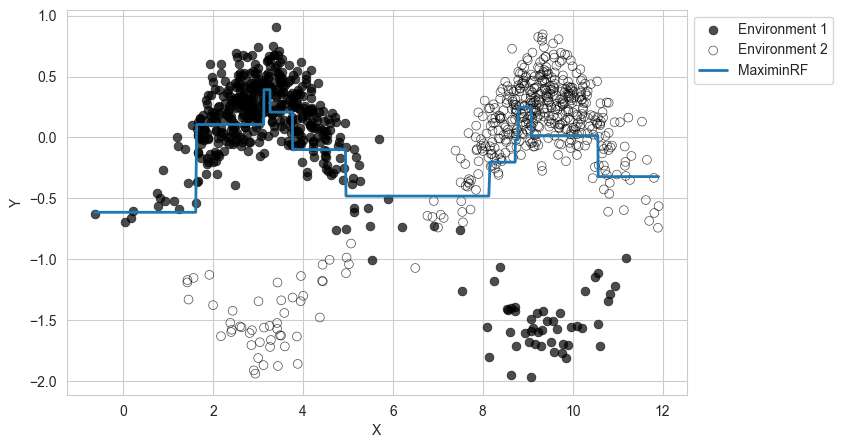

In [4]:
preds = rf.predict(Xtr_sorted)
dtr["X_sorted"] = Xtr_sorted
dtr["preds"] = preds

plt.figure(figsize=(8, 5))

scatter1 = sns.scatterplot(
    data=dtr[dtr["E"] == 0],
    x="X", y="Y",
    color="black", edgecolor="black",
    s=40, alpha=0.7,
    label="Environment 1"
)

scatter2 = sns.scatterplot(
    data=dtr[dtr["E"] == 1],
    x="X", y="Y",
    facecolors='none', edgecolor="black",
    s=40, alpha=0.7,
    label="Environment 2"
)

line1, = plt.plot(dtr["X_sorted"], dtr["preds"], linewidth=2, label="MaximinRF")

handles, labels = scatter1.get_legend_handles_labels()
method_legend = [line1]

plt.legend(handles=handles + method_legend, labels=labels, loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()
